In [4]:
import numpy as np
import matplotlib.pyplot as plt

import blacksky
import histlite as hl

In [5]:
from nsb.atmosphere import scattering, extinction
from nsb.emitter import moon, airglow, galactic, zodiacal, stars

from nsb import ASSETS_PATH
from nsb.core import Frame, Model
from nsb.core.instrument import Instrument, Camera, Bandpass

# Running the pipeline for pSCT

## Building the camera:
For cameras without raytraced response histograms, an analytical function can be used for 'pseudo-raytracing', as long as the camera geometry is implemented in ctapipe:

In [6]:
from ctapipe.visualization import CameraDisplay
from ctapipe.instrument import CameraGeometry
cam = CameraGeometry.from_name('SCTCam')

The psf needs to be a function of the off-axis angle, position angle and separation rho (all in radian). An approximate solution is to have a term that adds the standard deviation quadratically for an off-axis component and a base standard deviation. Here we tune the values to replicate the 80% containment radius of about 2.5 arcmin from arxiv:2010.13027.

In [30]:
%%time
c_bins = [np.linspace(0, np.deg2rad(5), 50), np.linspace(0, 2*np.pi, 20), np.linspace(0, 2*1e-3, 100)]

def psf(off, pos, rho):
    p = [0.41, 0.1]
    off = off/np.deg2rad(4)
    
    sigma = np.sqrt(p[0]**2 + p[1]*off**2)*1e-3
    
    return np.sin(rho)/(2*np.pi*sigma**2) * np.exp(-rho**2/(2*sigma**2))

h_psf = hl.hist_from_eval(psf, bins=c_bins)
cam = CameraGeometry.from_name('SCTCam')

sct_mirror_area = 50*0.88
sct_focal_length = 5.59

pSCT_cam = Camera.from_ctapipe(cam, h_psf, sct_mirror_area, sct_focal_length, d_grid=32)

CPU times: user 297 ms, sys: 8.84 ms, total: 306 ms
Wall time: 305 ms


As a bandpass we use the HESS bandpass. This likely underestimates the bandpass, since HESS1U is quite inefficent.

In [81]:
ct1_bandpass = Bandpass.from_csv(BANDPASS_PATH+'hess1u_ct1.dat')

## Creating the model:

In [82]:
# Sources:
glow = airglow.Noll2012({"H": 87})
zodi = zodiacal.Masana2021({})
jons = moon.Jones2013({})
scat = stars.GaiaDR3({'catalog_file':ASSETS_PATH+'gaiadr3.npy', 'magmin':-3, 'magmax':20})
smap = stars.GaiaDR3Mag15({'magnitude_maps':ASSETS_PATH+'gaia_mag15plus.npy'})

# Atmospheric Extinction:
atm_airglow = extinction.Noll2012({'scale':1.6, 'offset':-0.16})([glow])
atm_diffuse = extinction.Masana2021({'gamma':0.5})([zodi])
atm_stellar = extinction.Masana2021({'gamma':1})([scat, smap])

# Atmospheric Scattering:
conf_mie = {"parameters": [0.8],
            "bins": [np.linspace(0, np.pi, 1000)]}      
conf_ray = {"parameters": [0.0148],
            "bins": [np.linspace(0, np.pi, 1000)]}
atm_ray = scattering.Rayleigh(conf_ray)([jons]).map(np.deg2rad(180))
atm_mie = scattering.Mie(conf_mie)([jons]).map(np.deg2rad(180))

# Camera:
pSCT = Instrument({'camera':pSCT_cam, 'bandpass':ct1_bandpass}, 1)([atm_ray, atm_mie, atm_airglow, atm_diffuse, atm_stellar])

In [84]:
%%time
model = Model(pSCT)
model.compile()

/home/anonymous/src/blacksky/blacksky/photometric.py:32: RuntimeWarning: invalid value encountered in subtract
  color = magnitudes[j[0]] - magnitudes[j[1]]


CPU times: user 57.8 s, sys: 9.54 s, total: 1min 7s
Wall time: 1min 7s


## Predicting for IACTs:

In [85]:
import astropy
from astropy.coordinates import SkyCoord, EarthLocation, AltAz
import astropy.units as u

In [167]:
location = EarthLocation.from_geodetic(16.5028, -23.27280, 1800.)
obstime  = astropy.time.Time('2021-06-11T23:14:16', format='isot', scale='utc')
target   = SkyCoord.from_name('m7')

frame = Frame(location, obstime, target, 7, 0*u.deg, np.linspace(270, 730, 30)*u.nm, albedo=0.95, aero=[0.065, 1.2], sfu=75)

In [169]:
%%time
res = model.predict(frame)

CPU times: user 5.16 s, sys: 1.74 s, total: 6.89 s
Wall time: 6.97 s


## Visualizing:

In [170]:
def ctapipe_disp(cam, instrument, rays, ax, label='a.u.', **kwargs):
    display = CameraDisplay(cam, ax=ax, **kwargs)
    display.image = instrument.camera.pix_assign(rays)
    display.add_colorbar(label=label)
    return display

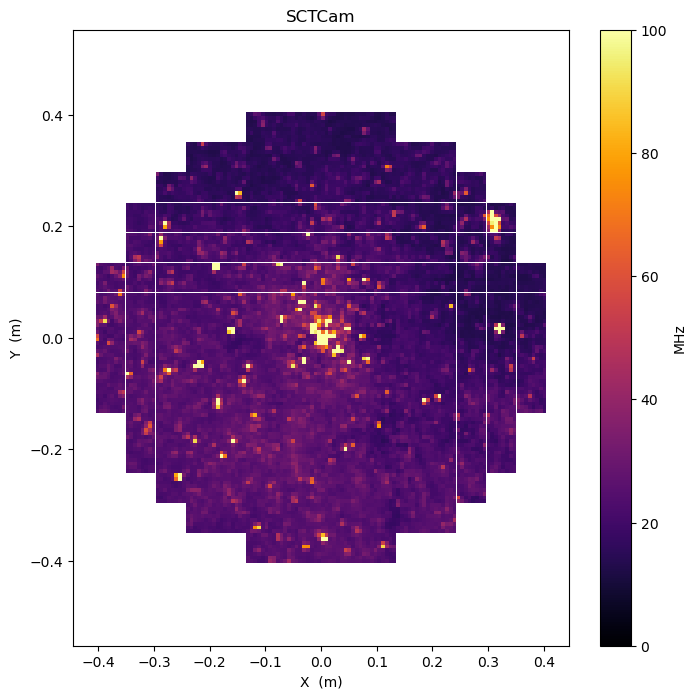

In [173]:
fig, ax = plt.subplots(figsize=(8,8))
disp = ctapipe_disp(cam, pSCT, res*1e-6, ax=ax, label='MHz', show_frame=False)
disp.set_limits_minmax(0, 100)

#fig.savefig("m7_pSCT.pdf", bbox_inches='tight')